Set `jupyter.notebookFileRoot` to `${workspaceFolder}`.

In [91]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression

import src.models.naive_bayes as naive_bayes
import src.models.logreg as logreg
from src.models.vectorization import CustomTfidfVectorizer
import src.models.tokenization as tkn


In [92]:
#frame = pd.read_csv("dataset.csv", delimiter=",", quotechar="'", names=("tweet", "label"))

path = "src/frontend_backend/datasetBalanced.xlsx" # adjust to where you keep the dataset

frame = pd.read_excel(
    path, 
    sheet_name="Worksheet", 
    header=None, 
    usecols="A:B", 
    names=("tweet", "label")
)

X = frame["tweet"].values
y = frame["label"].values 

print("tweets: size ", X.size)
print(X[:10])
print(y[:10])

print("AI tweets:", np.count_nonzero(y))

tweets: size  8254
['Why bother with these hearings when politicians have already made up their minds'
 "'I’m gonna get my gaming on. — KSI (@KSI) February 5,  2019 A great way to get your gaming on is to make a quick video about it. Here are some examples: How I'"
 "'If you are unsure,  ask the people who will be listening to your tweet. Do not use #hashtags (e.g. #femalefirst) or #hashtags with the hashtag symbol (e.g. #'"
 '@SJW Protests are good. Protests are bad. Protests are over. Protests are over. Protests are over. Protests are over. Protests are over. Protests are over. Protests are'
 "'Mark Wahlberg: ... Let''s just say If I had been at the Oscars it wouldn''t have gone down that way...'"
 'I think Reply Guy Kim and Alex Chillwavve have the best tree in all of DIY Christmas 😝,'
 'The Olympic Games are the pinnacle of sporting excellence. They are the pinnacle of sport. They are the pinnacle of sport. They are the pinnacle of sport. They are the pinnacle of sport. They are th

In [93]:
# Run if you wish to split phrases written in Pascal case
X = list(map(tkn.split_pascals, X))

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    #train_size=5000, test_size=1000
                                                   )

The accuracy of custom vectorization was above baseline on the unbalanced set, about 0.7. On the balanced set, however, its performance becomes abysmal. I therefore suspect that my implementation is incorrect.

In [95]:
# Custom-preprocessed sets
custom_vec = CustomTfidfVectorizer(min_df=5, max_df_ratio=0.6)

X_train_custom_prep = custom_vec.fit_transform(X_train)
X_test_custom_prep = custom_vec.transform(X_test)

In [96]:
# Sklearn-preprocessed sets
sklearn_vec = TfidfVectorizer(min_df=5, max_df=0.6, sublinear_tf=True)

X_train_sklearn_prep = sklearn_vec.fit_transform(X_train).toarray()
X_test_sklearn_prep = sklearn_vec.transform(X_test).toarray()

In [97]:
# Custom logistic regression 
lr = logreg.LogisticRegressionModel()

## on custom-preprocessed data
lr.train(X_train_custom_prep, y_train)

accuracy = (lr.classify(X_test_custom_prep) == y_test).mean()
print("Accuracy logreg custom/custom: ", accuracy)

## on sklearn-preprocessed data
lr.train(X_train_sklearn_prep, y_train)

accuracy = (lr.classify(X_test_sklearn_prep) == y_test).mean()
print("Accuracy logreg sklearn/custom: ", accuracy)

Accuracy logreg custom/custom:  0.499031007751938
Accuracy logreg sklearn/custom:  0.8464147286821705


In [98]:
# Custom naive Bayes
nb = naive_bayes.NaiveBayesModel()

# it uses its own preprocessing
X_train_bayes = nb.preprocess_set(X_train)
X_test_bayes = nb.preprocess_set(X_test)

nb.train(X_train_bayes, y_train)

results = nb.classify(X_test_bayes)
correct = 0
for result, label in zip(results, y_test):
    if result == label:
        correct += 1
acc = correct/len(y_test)
print("Accuracy custom Bayes: ", acc)

Accuracy custom Bayes:  0.8900193798449613


---

**A little addition**  
Let us find the words most characteristic for AI. We will train naive Bayes on the whole balanced set and plot the distribution of human/ai ratios.

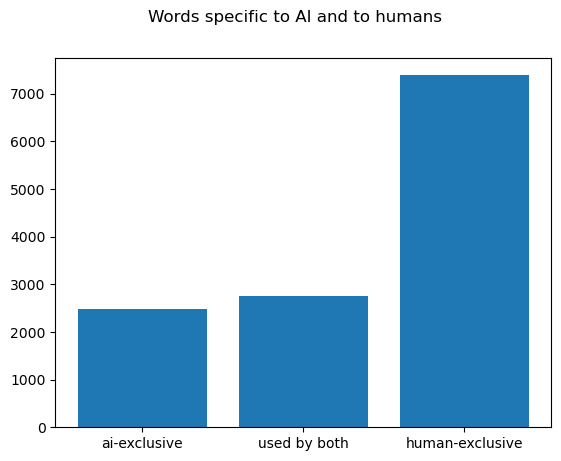

In [101]:
nb.train(nb.preprocess_set(X), y)

words = np.array(list(nb.dictionary.keys()))

pairs = nb.dictionary.values()
unzipped = list(zip(*pairs))

human_counts = np.array(unzipped[0])
ai_counts = np.array(unzipped[1])

idx_both = np.logical_and(human_counts > 0, ai_counts > 0)

import matplotlib.pyplot as plt
names = ["ai-exclusive", "used by both", "human-exclusive"]
values = [np.count_nonzero(human_counts == 0), 
          np.count_nonzero(idx_both),
          np.count_nonzero(ai_counts == 0)]
plt.figure()
plt.bar(names, values)
plt.suptitle("Words specific to AI and to humans")
plt.show()


Text(0.5, 1.0, 'Distribution of ratios')

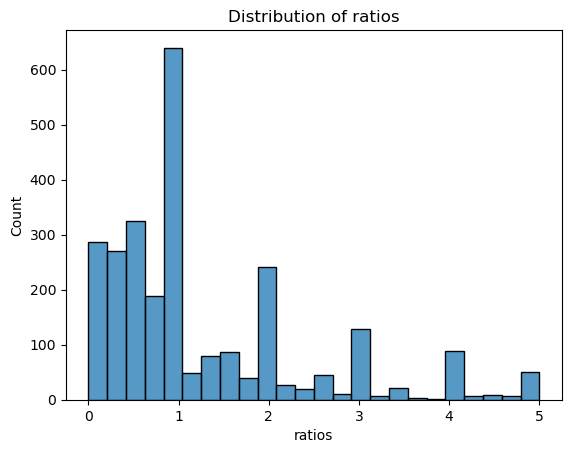

In [90]:
ratios = human_counts[idx_both]/ai_counts[idx_both]


import seaborn as sns
p = sns.histplot(pd.DataFrame(ratios, columns=("ratios",)), x="ratios", 
                 binrange=(0, 5), #binwidth=0.1
                )
p.set_title("Distribution of ratios")

In [102]:
top = np.argsort(ratios)[:300]

print("Typical AI words that have been used by humans")
print(words[idx_both][top])
print(ratios[top])

Typical AI words that have been used by humans
['latest' 'hashtag' 'hashtags' 'possibilities' 'endless' 'casual' 'hey'
 'tweeting' 'impact' 'town' 'bright' 'tweet' 'create' 'include'
 'application' 'article' 'paving' 'transforming' 'somewhere' 'ideas'
 'diversity' 'lately' 'basics' 'raise' 'inspiration' 'discuss' 'describe'
 'moves' 'tweets' 'followers' 'weirdest' 'topic' 'globalevents' 'movement'
 'intersection' 'lie' 'emoji' 'spread' 'shake' 'startups' 'revolutionize'
 'received' 'advice' 'sharing' 'glad' 'use' 'etc' 'word' 'share'
 'creative' 'example' 'twitter' 'term' 'message' 'global' 'following'
 'news' 'underrated' 'language' 'settle' 'andor' 'daily' 'tuned'
 'knowledge' 'step' 'keeps' 'excited' 'write' 'iphone' 'insights' 'cyber'
 'thanksgiving' 'don' 'easier' 'sure' 'thoughts' 'add' 'fan' 'connect'
 'climate' 'tag' 'exciting' 'weather' 'users' 'solution' 'service'
 'friday' 'events' 'make' 'todays' 'feminist' 'keeping' 'debate' 'ways'
 'change' 'also' 'trending' 'hand' 'pets'

---

In [99]:
# Sklearn's LogisticRegression
slr = LogisticRegression(penalty=None)

## on custom-preprocessed data
slr.fit(X_train_custom_prep, y_train)

accuracy = (slr.predict(X_test_custom_prep) == y_test).mean()
print("Accuracy logreg custom/sklearn: ", accuracy)

## on sklearn-preprocessed data
slr.fit(X_train_sklearn_prep, y_train)

accuracy = (slr.predict(X_test_sklearn_prep) == y_test).mean()
print("Accuracy logreg sklearn/sklearn: ", accuracy)

Accuracy logreg custom/sklearn:  0.499031007751938
Accuracy logreg sklearn/sklearn:  0.8609496124031008


In [100]:
# Sklearn's ComplementNB
cnb = ComplementNB()

## on custom-preprocessed data
cnb.fit(X_train_custom_prep, y_train)

accuracy = (cnb.predict(X_test_custom_prep) == y_test).mean()
print("Accuracy Bayes custom/sklearn: ", accuracy)

## on sklearn-preprocessed data
cnb.fit(X_train_sklearn_prep, y_train)

accuracy = (cnb.predict(X_test_sklearn_prep) == y_test).mean()
print("Accuracy Bayes sklearn/sklearn: ", accuracy)

Accuracy Bayes custom/sklearn:  0.500968992248062
Accuracy Bayes sklearn/sklearn:  0.8633720930232558
